In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

from zipfile import ZipFile
zipped = ZipFile("101_food_classes_10_percent.zip")
zipped.extractall()
zipped.close()

--2022-06-30 14:09:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   198MB/s    in 8.1s    

2022-06-30 14:09:45 (192 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [2]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [3]:
import os
for path, dirs, files in os.walk("101_food_classes_10_percent"):
  print(f"There are {len(dirs)} dirs and {len(files)} files in {path}")

There are 2 dirs and 0 files in 101_food_classes_10_percent
There are 101 dirs and 0 files in 101_food_classes_10_percent/train
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/waffles
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/hummus
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/eggs_benedict
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/caprese_salad
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/churros
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/macaroni_and_cheese
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/spaghetti_bolognese
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/hot_dog
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/french_onion_soup
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/cheesecake
There are 0 dirs and 75 files in 101_food_classes_10_percent/train/foie_gr

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
IMAGE_SHAPE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMAGE_SHAPE,
                                                                 label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMAGE_SHAPE,
                                                                label_mode="categorical",
                                                                shuffle=False)

print(f"Num of classes: {len(train_data.class_names)}")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.
Num of classes: 101


In [6]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomContrast(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation")

data_augmentation.layers

In [7]:
checkpoint_path = "checkpoints/model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy")

In [8]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False
  
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [9]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 1,022,613
Non-train

In [10]:
history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 146s 538ms/step - loss: 2.9440 - accuracy: 0.3160 - val_loss: 1.9132 - val_accuracy: 0.4978
Epoch 2/5
237/237 [==============================] - 103s 435ms/step - loss: 1.8925 - accuracy: 0.5245 - val_loss: 1.6896 - val_accuracy: 0.5524
Epoch 3/5
237/237 [==============================] - 97s 411ms/step - loss: 1.5365 - accuracy: 0.6025 - val_loss: 1.5998 - val_accuracy: 0.5766
Epoch 4/5
237/237 [==============================] - 95s 402ms/step - loss: 1.2841 - accuracy: 0.6607 - val_loss: 1.5623 - val_accuracy: 0.5878
Epoch 5/5
237/237 [==============================] - 92s 387ms/step - loss: 1.0989 - accuracy: 0.7038 - val_loss: 1.5831 - val_accuracy: 0.5875


In [11]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]
  epochs = np.arange(0, len(loss))

  plt.figure(figsize=(10, 14))
  plt.subplot(2, 1, 1)
  plt.title("Accuracy")
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.title("Loss")
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.legend()

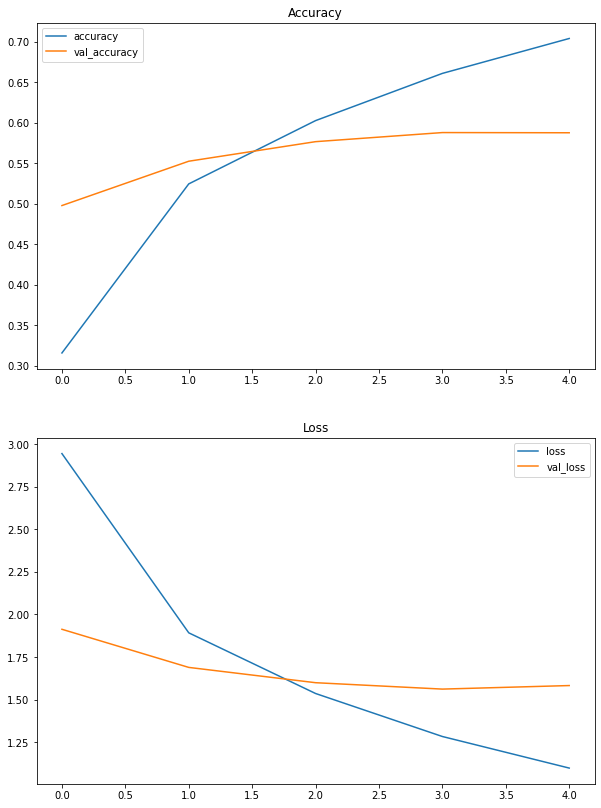

In [12]:
plot_loss_curves(history_1)

In [13]:
model_1.evaluate(test_data)

790/790 [==============================] - 57s 71ms/step - loss: 1.5831 - accuracy: 0.5875


[1.5830742120742798, 0.5875247716903687]

## Conclusion: Might be overfitting

In [14]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=["accuracy"])

history_12 = model_1.fit(train_data,
                         epochs=10,
                         steps_per_epoch=len(train_data),
                         validation_data=test_data,
                         validation_steps=len(test_data),
                         initial_epoch=history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 96s 378ms/step - loss: 0.7833 - accuracy: 0.8011 - val_loss: 1.4801 - val_accuracy: 0.6080
Epoch 6/10
237/237 [==============================] - 89s 375ms/step - loss: 0.7016 - accuracy: 0.8288 - val_loss: 1.4644 - val_accuracy: 0.6127
Epoch 7/10
237/237 [==============================] - 115s 486ms/step - loss: 0.6724 - accuracy: 0.8346 - val_loss: 1.4549 - val_accuracy: 0.6147
Epoch 8/10
237/237 [==============================] - 84s 353ms/step - loss: 0.6491 - accuracy: 0.8428 - val_loss: 1.4449 - val_accuracy: 0.6173
Epoch 9/10
237/237 [==============================] - 83s 348ms/step - loss: 0.6035 - accuracy: 0.8580 - val_loss: 1.4505 - val_accuracy: 0.6159
Epoch 10/10
237/237 [==============================] - 82s 344ms/step - loss: 0.5966 - accuracy: 0.8618 - val_loss: 1.4560 - val_accuracy: 0.6154


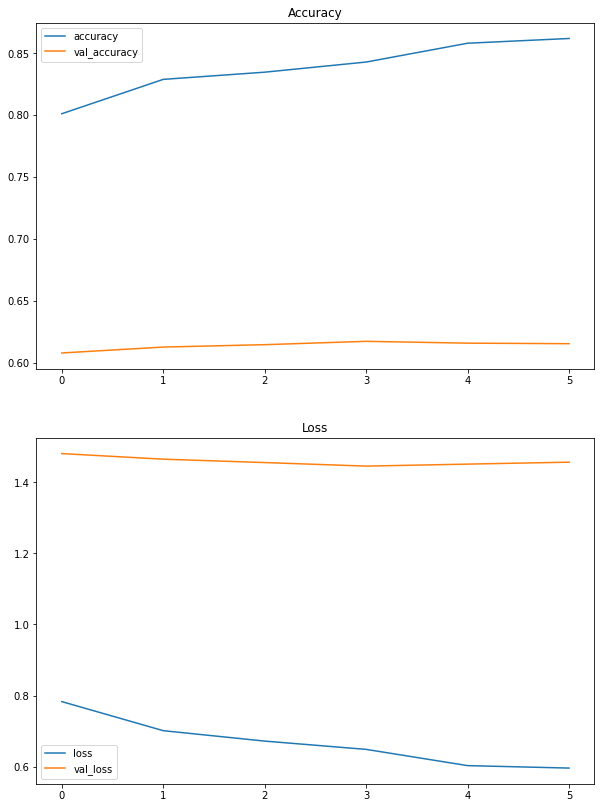

In [15]:
plot_loss_curves(history_12)

In [16]:
model_1.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.4560 - accuracy: 0.6154


[1.45601487159729, 0.6154455542564392]

In [17]:
pred_probs = model_1.predict(test_data, verbose=1)

pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

790/790 [==============================] - 62s 78ms/step


0.6154455445544554

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.20      0.25       250
           1       0.48      0.74      0.58       250
           2       0.68      0.63      0.65       250
           3       0.80      0.52      0.63       250
           4       0.66      0.43      0.52       250
           5       0.57      0.38      0.45       250
           6       0.73      0.78      0.76       250
           7       0.87      0.71      0.78       250
           8       0.28      0.52      0.36       250
           9       0.47      0.59      0.53       250
          10       0.57      0.49      0.52       250
          11       0.81      0.59      0.69       250
          12       0.78      0.58      0.67       250
          13       0.55      0.57      0.56       250
          14       0.56      0.57      0.56       250
          15       0.38      0.38      0.38       250
          16       0.75      0.49      0.59       250
          17       0.45    